# DNN SOM

## Imports & Globals

In [33]:
## Imports
from sklearn.metrics import classification_report
import classifiers
from data import mfcc_arr, pca_matrix
import pickle
from collections import defaultdict
from functools import partial
from itertools import count
import numpy as np
from sklearn.model_selection import train_test_split
from minisom import MiniSom
import torch
import torch.nn as nn
import torch.optim as optim

torch.device("cuda")

## Globals
# Dataset
DATASET = "16000_pcm_speeches"
PCA_COMPONENTS = 80
AUDIO_TIME = 0.99 #sec

# Model
SOM_NAME = "NN_SOM"
MSIZE = [32, 1]
NRADIUS = 2.0
REF_SOM_EPOCHS = 5000
SOM_EPOCHS = 50
LEARN_RATE = 0.5
NN_EPOCHS = 50
NN_BATCH = 20
CLASSES = 5
LAMBDA = 5

## Dataset

Create data files from raw audio

In [ ]:
mfcc_arr(DATASET, AUDIO_TIME)
pca_matrix(DATASET, AUDIO_TIME, PCA_COMPONENTS)

Processing Data


  0%|          | 0/10500 [00:00<?, ?it/s]

100%|██████████| 10500/10500 [00:30<00:00, 339.80it/s]


Data Shape: (10500, 620)


Load data files

In [34]:
with open('./data_files/' + DATASET + "/" + str(AUDIO_TIME) + "sec_" + str(PCA_COMPONENTS) + "PCA_data.p", 'rb') as infile:
#with open('./data_files/' + DATASET + "/" + str(AUDIO_TIME) + "sec_" + "data.p", 'rb') as infile:
    data = pickle.load(infile)
with open('./data_files/' + DATASET + "/" + str(AUDIO_TIME) + "sec_labels.p", 'rb') as infile:
    labels = pickle.load(infile)

print(np.shape(data))
print(np.shape(labels))

(6777, 80)
(6777,)


Format data

In [35]:
#labels = [int(i) for i in labels]
label_to_number = defaultdict(partial(next, count(1)))
y = np.zeros((len(labels), len(np.unique(labels))))
for i in range(len(labels)):
    y[i][label_to_number[labels[i]] - 1] = 1
 
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.1, train_size = 0.9, stratify=y)
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

print(X_train.shape)
print(y_train.shape)

torch.Size([6099, 80])
torch.Size([6099, 5])


## Model

DNN's SOM

In [36]:
dnn_som = MiniSom(
    x             = MSIZE[0], 
    y             = MSIZE[1], 
    input_len     = 64,
    sigma         = NRADIUS,
    learning_rate = LEARN_RATE,
    random_seed   = None)

print(dnn_som._weights.shape)

(32, 1, 64)


DNN

In [37]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(X_train.shape[1], 64)
        self.a1 = nn.ReLU()
        self.h2 = nn.Linear(64, 32)
        self.a2 = nn.ReLU()
        self.out = nn.Linear(32, CLASSES)
        self.a_out = nn.Sigmoid()
    def forward(self, x):
        x = self.a1(self.h1(x))
        x_som = torch.clone(x).detach().numpy()
        x = self.a2(self.h2(x))

        dnn_som._weights = torch.clone(self.h2.weight).detach().numpy()
        dnn_som._weights = np.reshape(dnn_som._weights, (32, 1, 64))
        dnn_som.train_random(x_som, SOM_EPOCHS, verbose = False)
        self.h2.weight = torch.nn.parameter.Parameter(torch.tensor(np.reshape(dnn_som._weights, (32, 64))))

        x = self.a_out(self.out(x))
        return x, x_som
model = DNN()

Reference SOM

In [38]:
som = MiniSom(
    x             = MSIZE[0], 
    y             = MSIZE[1], 
    input_len     = X_train[0].shape[0],
    sigma         = NRADIUS,
    learning_rate = LEARN_RATE,
    random_seed   = None)

Reference DNN

In [39]:
class REFDNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(X_train.shape[1], 64)
        self.a1 = nn.ReLU()
        self.h2 = nn.Linear(64, 32)
        self.a2 = nn.ReLU()
        self.out = nn.Linear(32, CLASSES)
        self.a_out = nn.Sigmoid()
    def forward(self, x):
        x = self.a1(self.h1(x))
        x = self.a2(self.h2(x))
        x = self.a_out(self.out(x))
        return x

ref_dnn = REFDNN()
print(ref_dnn)

REFDNN(
  (h1): Linear(in_features=80, out_features=64, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=64, out_features=32, bias=True)
  (a2): ReLU()
  (out): Linear(in_features=32, out_features=5, bias=True)
  (a_out): Sigmoid()
)


## Training

DNN SOM

In [ ]:
## TODO: Regular Cross Entropy Loss
## TODO: Take the bus the healys lab
## TODO: Try with CNN
## TODO: Visualization

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
 
epoch_x = []
loss_y = []
acc_y = []
for epoch in range(NN_EPOCHS):
    epoch_x.append(epoch)

    for i in range(0, len(X_train), NN_BATCH):
        Xbatch = X_train[i:i+NN_BATCH]
        y_pred, x_som = model(Xbatch)
        ybatch = y_train[i:i+NN_BATCH]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        nn_y_pred, SOM_X_train = model(X_train)

    if epoch == 0: dnn_som.random_weights_init(SOM_X_train)
    acc_y.append((nn_y_pred.round() == y_train).float().mean())
    loss_y.append(loss)
    if epoch % 10 == 0: print(f'Epoch: {epoch}| Loss: {loss}')

with torch.no_grad():
    dnnsom_nn_y_pred, SOM_X_train = model(X_train)
    dnnsom_nn_y_pred_test, SOM_X_test = model(X_test)



Epoch: 0| Loss: 1.50896418094635
Epoch: 10| Loss: 1.8821401596069336
Epoch: 20| Loss: 1.6321722269058228
Epoch: 30| Loss: 1.6321722269058228
Epoch: 40| Loss: 1.6321722269058228


Reference SOM

In [41]:
som.random_weights_init(X_train)
som.train_random(X_train, REF_SOM_EPOCHS, verbose = True)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 381.2248095046565


Reference DNN

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(ref_dnn.parameters(), lr=0.01)
 
epoch_x = []
loss_y = []
acc_y = []
for epoch in range(NN_EPOCHS):
    epoch_x.append(epoch)

    for i in range(0, len(X_train), NN_BATCH):
        Xbatch = X_train[i:i+NN_BATCH]
        y_pred = ref_dnn(Xbatch)
        ybatch = y_train[i:i+NN_BATCH]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        nn_y_pred = ref_dnn(X_train)

    acc_y.append((nn_y_pred.round() == y_train).float().mean())
    loss_y.append(loss)
    if epoch % 10 == 0: print(f'Epoch: {epoch}| Loss: {loss}')

with torch.no_grad():
    refdnn_nn_y_pred = ref_dnn(X_train)
    refdnn_nn_y_pred_test = ref_dnn(X_test)


Epoch: 0| Loss: 0.9929715394973755
Epoch: 10| Loss: 0.9061583280563354
Epoch: 20| Loss: 0.9060190320014954
Epoch: 30| Loss: 0.9057531952857971
Epoch: 40| Loss: 0.9053000211715698


## Evaluation

DNN SOM - SOM

In [44]:
dnn_som_y_pred = torch.stack(classifiers.classify_BMU(dnn_som, SOM_X_test, SOM_X_train, y_train), dim = 0)
print(classification_report(y_test, dnn_som_y_pred))
accuracy = (dnn_som_y_pred == y_test).float().mean()
print(f"DNN-SOM Test Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.42      0.35      0.38       150
           1       0.52      0.58      0.55       150
           2       0.43      0.46      0.45       150
           3       0.62      0.49      0.54       150
           4       0.29      0.40      0.33        78

   micro avg       0.46      0.46      0.46       678
   macro avg       0.45      0.45      0.45       678
weighted avg       0.47      0.46      0.46       678
 samples avg       0.46      0.46      0.46       678

DNN-SOM Test Accuracy: 0.7840707898139954


DNN SOM - DNN

In [ ]:
accuracy = (dnnsom_nn_y_pred_test.round() == y_test).float().mean()
print(f"NN Test Accuracy: {accuracy}")

NN Test Accuracy: 0.9967551827430725


Reference SOM

In [46]:
som_y_pred = torch.stack(classifiers.classify_BMU(som, X_test, X_train, y_train), dim = 0)
print(classification_report(y_test, som_y_pred))
accuracy = (som_y_pred == y_test).float().mean()
print(f"SOM Test Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       150
           1       0.84      0.89      0.86       150
           2       0.36      0.24      0.29       150
           3       0.69      0.63      0.66       150
           4       0.24      0.33      0.28        78

   micro avg       0.60      0.60      0.60       678
   macro avg       0.56      0.58      0.56       678
weighted avg       0.60      0.60      0.59       678
 samples avg       0.60      0.60      0.60       678

SOM Test Accuracy: 0.8407079577445984


Reference DNN

In [ ]:
accuracy = (refdnn_nn_y_pred_test.round() == y_test).float().mean()
print(f"NN Test Accuracy: {accuracy}")

NN Test Accuracy: 0.9967551827430725


# Visualization

## Reference DNN

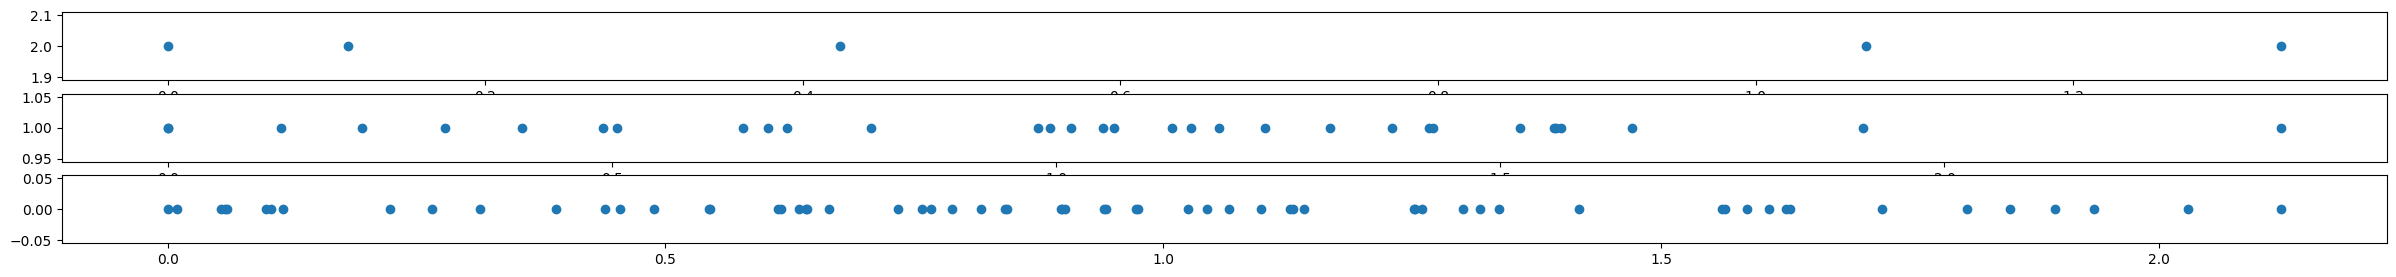

In [48]:
import math
import matplotlib.pyplot as plt

layers = [ref_dnn.h1.weight, ref_dnn.h2.weight, ref_dnn.out.weight]
x = [] 
y = []
i = 0
f, axis = plt.subplots(3, 1)
f.set_figheight(3)
f.set_figwidth(30)
for layer in layers:
    x = [] 
    y = []
    center = int(np.round(layer.shape[0]/2))
    for node in layer:
        y.append(i)
        diff = node - layer[center]
        x.append(np.abs(np.sum(diff.detach().numpy())))
    axis[2-i].scatter(x, y)
    i += 1



## DNN-SOM

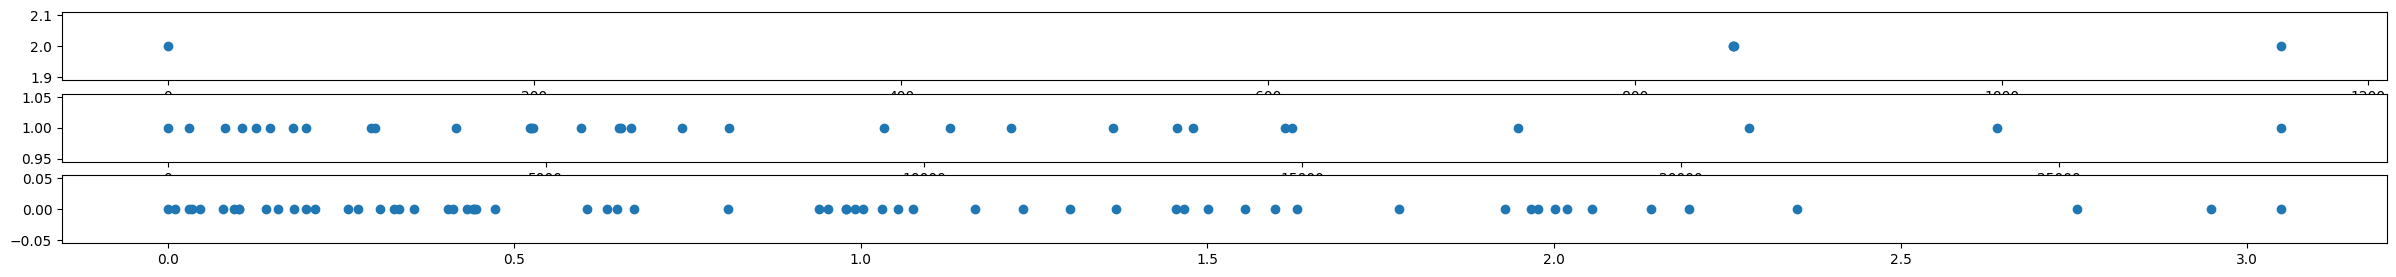

In [49]:
import math
import matplotlib.pyplot as plt

layers = [model.h1.weight, model.h2.weight, model.out.weight]
x = [] 
y = []
i = 0
f, axis = plt.subplots(3, 1)
f.set_figheight(3)
f.set_figwidth(30)
for layer in layers:
    x = [] 
    y = []
    center = int(np.round(layer.shape[0]/2))
    for node in layer:
        y.append(i)
        diff = node - layer[center]
        x.append(np.abs(np.sum(diff.detach().numpy())))
    axis[2-i].scatter(x, y)
    i += 1

## Ref SOM

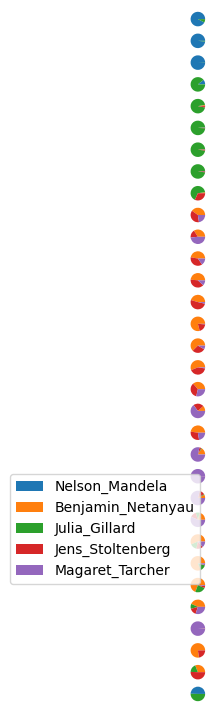

In [50]:
import matplotlib.gridspec as gridspec

label_names = list(set(labels))
labels_map = som.labels_map(data, labels)

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(MSIZE[0], MSIZE[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[MSIZE[0]-1-position[0], position[1]], aspect=1)
    #plt.subplot(the_grid[som.x-1-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names)
plt.show()

## DNN SOM

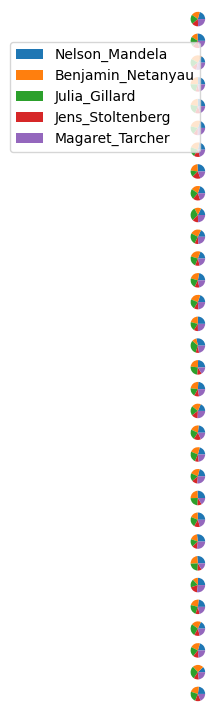

In [51]:
# TODO: Seperate Pie Charts for train/test
# TODO: Layer by Layer DNN visualizations
# TODO: Introduce lambda term to SOM

label_names = list(set(labels))
som_x = np.concatenate((SOM_X_train, SOM_X_test))
labels_map = dnn_som.labels_map(som_x, labels)

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(MSIZE[0], MSIZE[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[MSIZE[0]-1-position[0], position[1]], aspect=1)
    #plt.subplot(the_grid[som.x-1-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names)
plt.show()